In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

%matplotlib inline
plt.rcParams['figure.figsize'] = (25, 10)

# Thresholding

In [2]:
from skimage.filters import try_all_threshold, threshold_otsu, threshold_triangle, threshold_yen

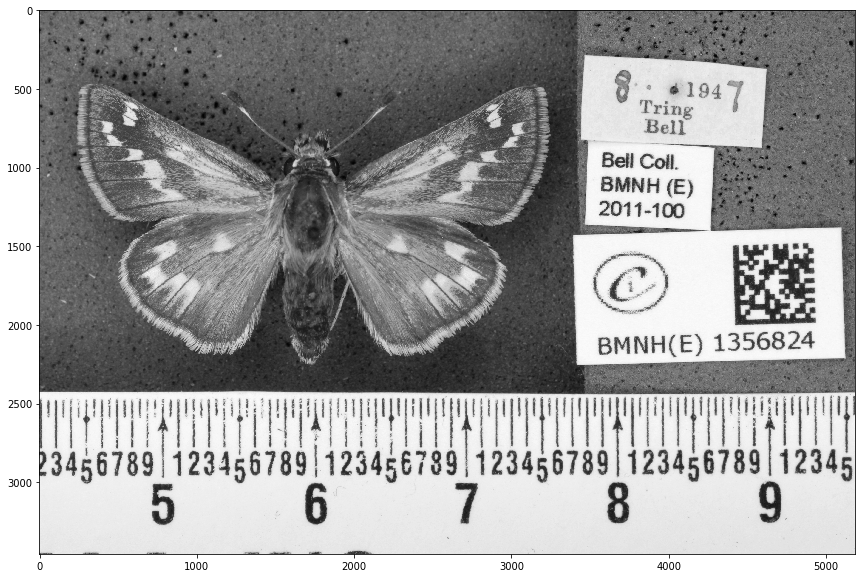

In [3]:
image = imread("data/test_pictures/BMNHE_1356824.jpg")[:, :, 0]
plt.imshow(image, cmap=plt.cm.gray)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<matplotlib.figure.Figure at 0x219fb677198>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000219FCD307B8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000219837C3390>], dtype=object))

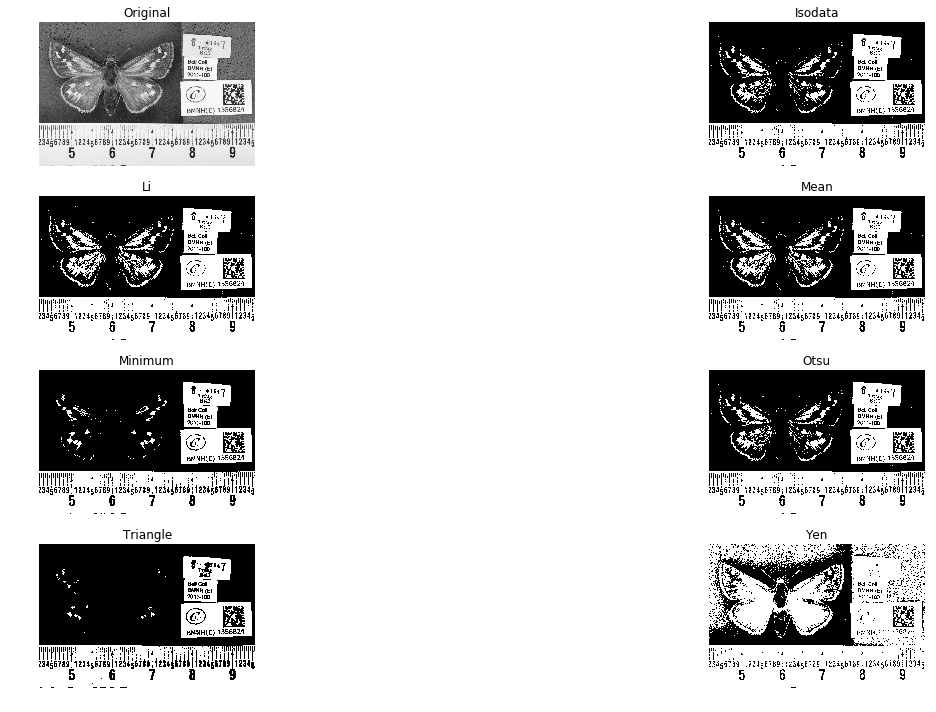

In [4]:
try_all_threshold(image, figsize=(25, 10))

(3456, 5184)


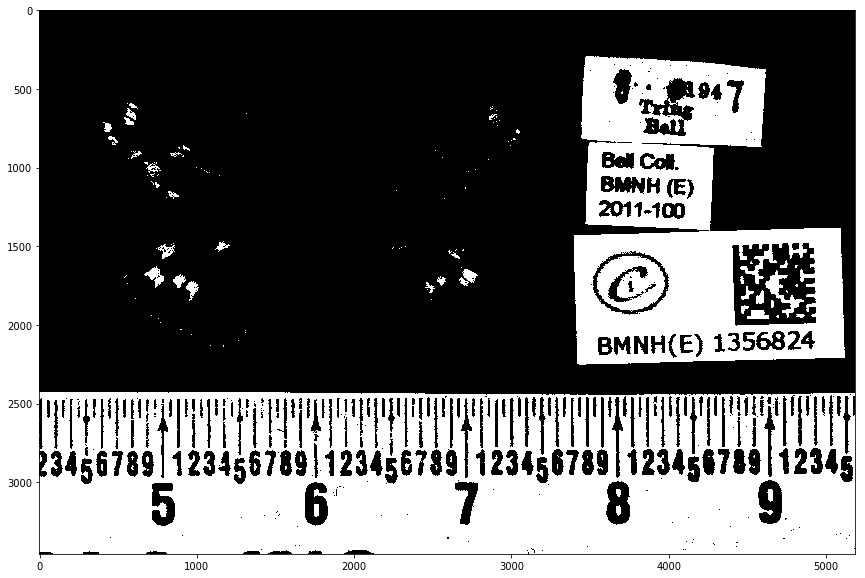

In [5]:
thresh = threshold_triangle(image)
binary = image > thresh
plt.imshow(binary, cmap=plt.cm.gray)

print(binary.shape)

# Step Detection

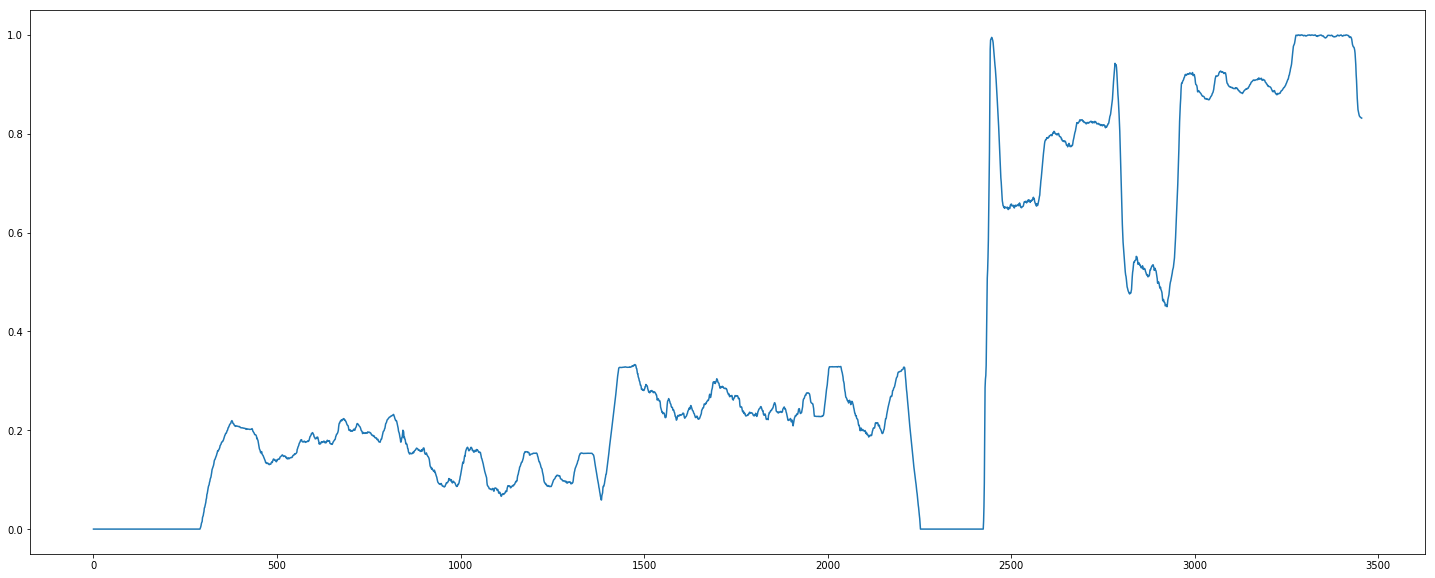

In [6]:
avg_row_values = np.mean(binary, 1)
plt.plot(avg_row_values)

2441


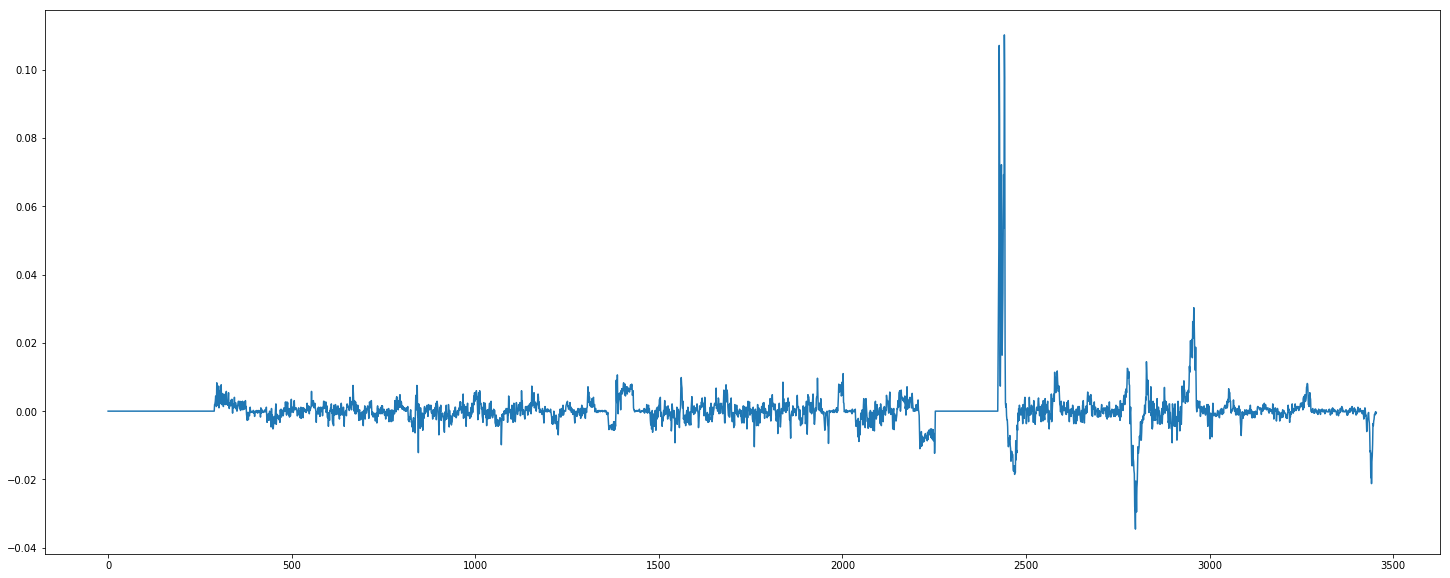

In [7]:
row_diff = np.diff(avg_row_values, n=1)
plt.plot(row_diff)
biggest_diff = np.argmax(row_diff)
print(biggest_diff)

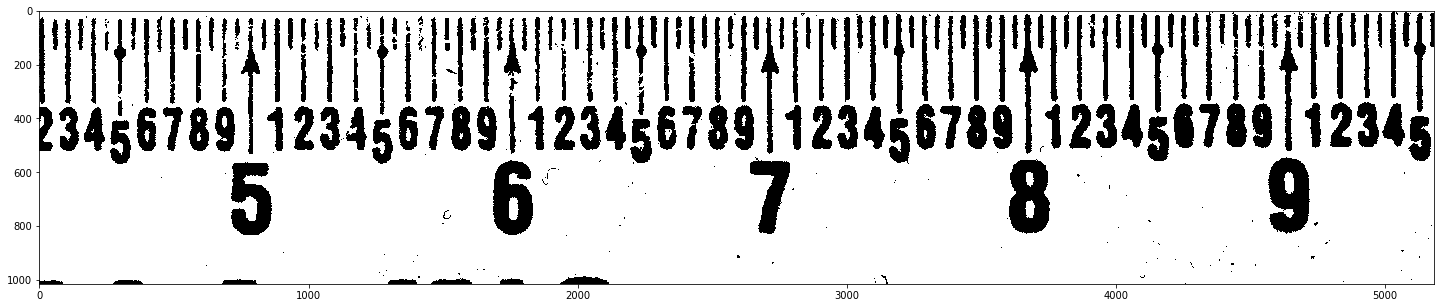

In [8]:
ruler_step_detect = binary[2441:]
plt.imshow(ruler_step_detect, cmap=plt.cm.gray)

In [9]:
def get_ruler_edge(binary, diff_n=1):
    avg_row_values = np.mean(binary, 1)
    row_diff = np.diff(avg_row_values, n=diff_n)
    return np.argmax(row_diff)

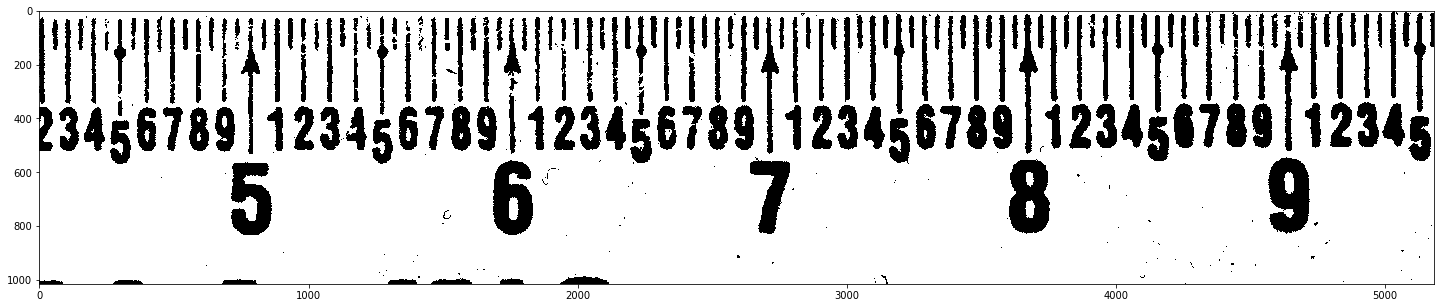

In [10]:
ruler_edge_position = get_ruler_edge(binary)
plt.imshow(binary[ruler_edge_position:], cmap=plt.cm.gray)

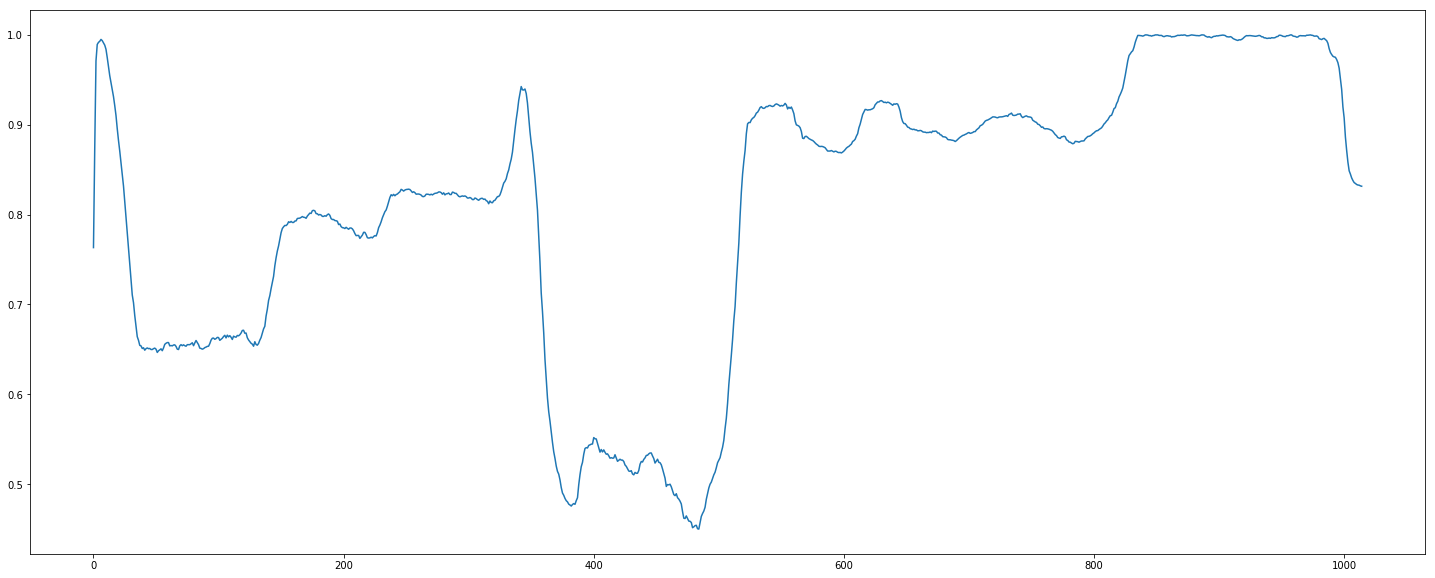

In [11]:
ruler_edge_position = get_ruler_edge(binary)
binary_ruler_only = binary[ruler_edge_position:]
avg_ruler_row_values = np.mean(binary_ruler_only, 1)
plt.plot(avg_ruler_row_values)

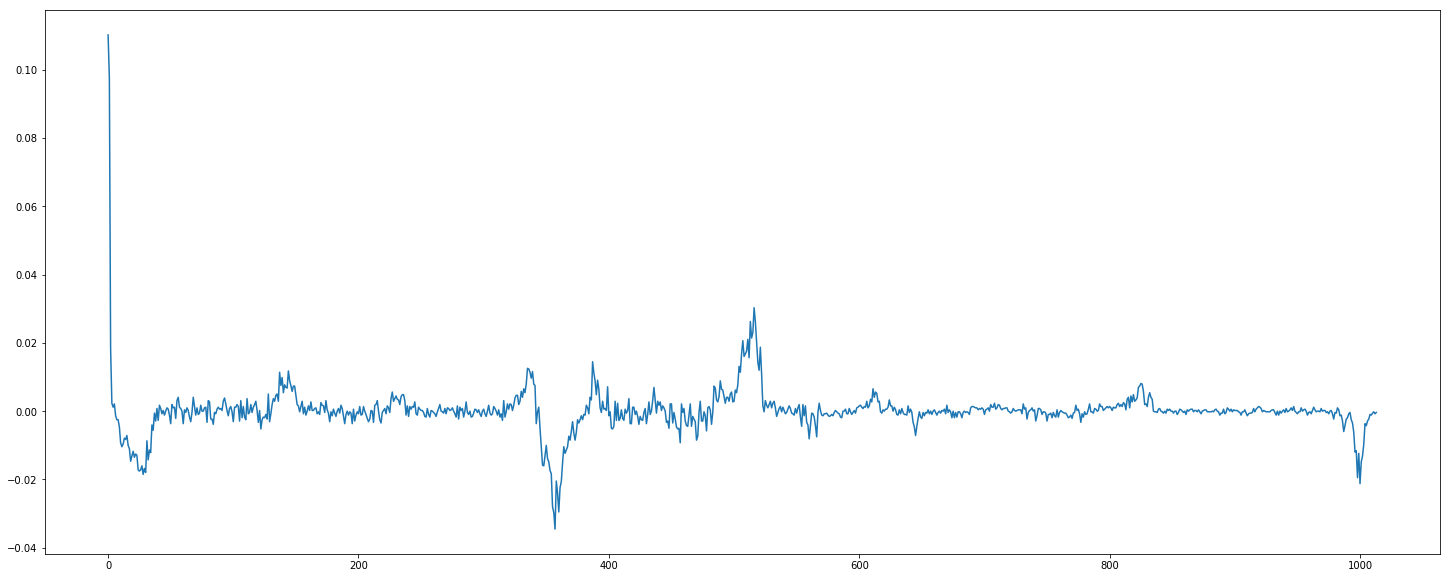

In [12]:
ruler_row_diff = np.diff(avg_ruler_row_values, 1)
plt.plot(ruler_row_diff)

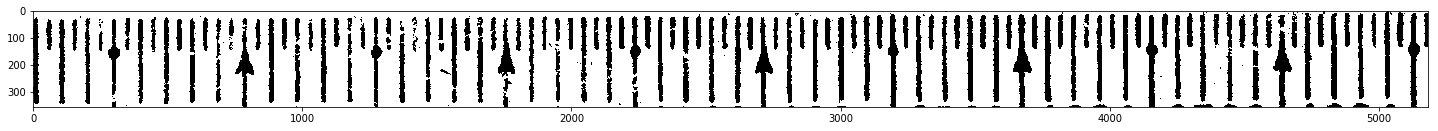

In [13]:
ruler_numbers_cutoff = np.argmin(ruler_row_diff)
plt.imshow(binary_ruler_only[:ruler_numbers_cutoff], cmap=plt.cm.gray)

In [14]:
def get_ruler_numbers_edge(binary_ruler_only, diff_n=1):
    avg_ruler_row_values = np.mean(binary_ruler_only, 1)
    ruler_row_diff = np.diff(avg_ruler_row_values, 1)
    return np.argmin(ruler_row_diff)

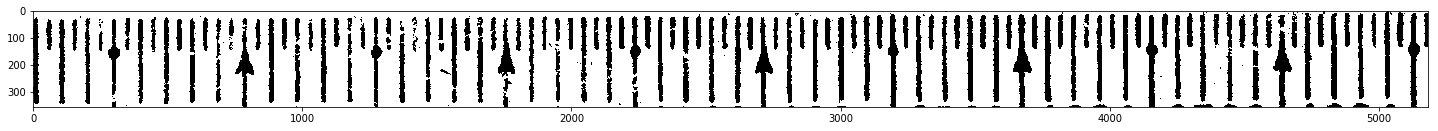

In [15]:
ruler_numbers_cutoff = get_ruler_numbers_edge(binary_ruler_only)
plt.imshow(binary_ruler_only[:ruler_numbers_cutoff], cmap=plt.cm.gray)

# Convolution

In [16]:
from scipy.ndimage.filters import convolve

In [17]:
kernel_height = 20
kernel_zeros = -np.ones((kernel_height//2, binary.shape[1]))
kernel_ones = np.ones((kernel_height//2, binary.shape[1]))
kernel = np.concatenate((kernel_zeros, kernel_ones), axis=0)

# kernel /= np.sum(kernel)
print(kernel.shape)
kernel

(20, 5184)


array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

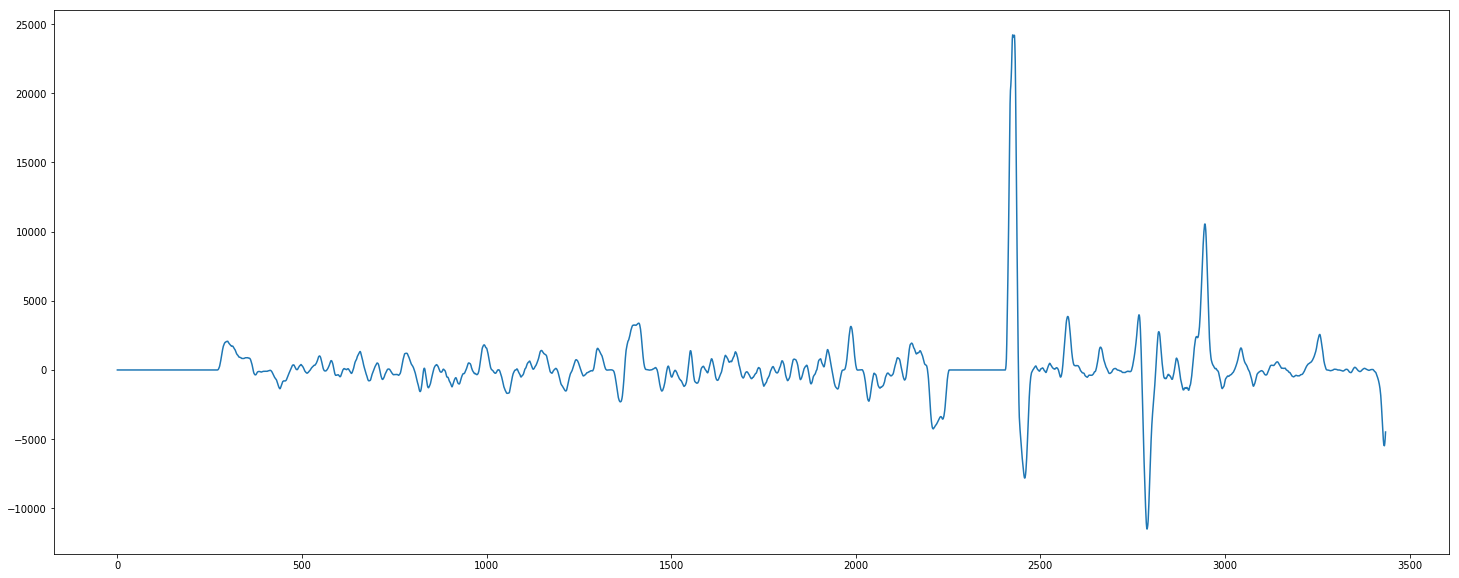

In [18]:
convolve_result = np.empty(binary.shape[0] - kernel_height)

for i in range(convolve_result.shape[0]):
    splice = binary[i: i+kernel_height]
    mul_result = np.multiply(kernel, splice)
    convolve_result[i] = np.sum(mul_result)
    
plt.plot(convolve_result)

In [19]:
cutoff = np.argmax(convolve_result) + kernel_height//2

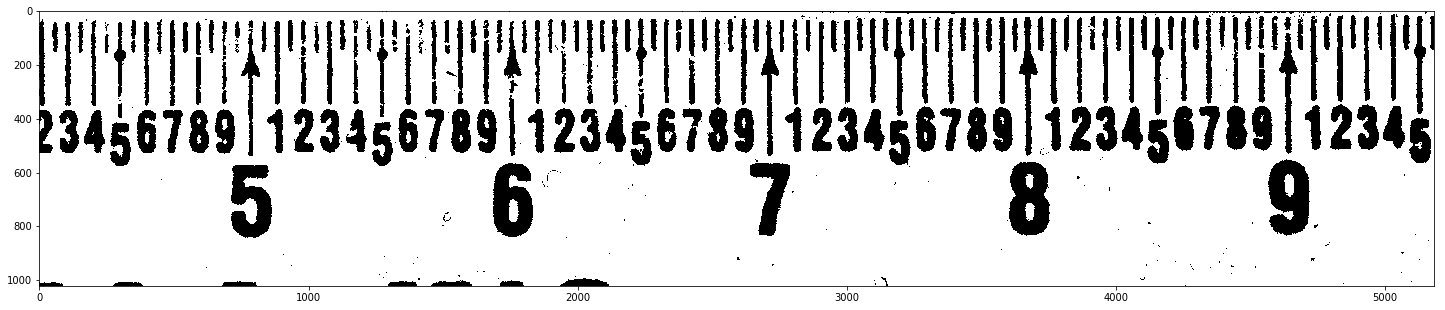

In [20]:
ruler_convolution = binary[cutoff:]
plt.imshow(ruler_convolution, cmap=plt.cm.gray)

In [21]:
def get_ruler_edge_convolution(binary, kernel_height):
    kernel_neg_ones = -np.ones((kernel_height//2, binary.shape[1]))
    kernel_ones = np.ones((kernel_height//2, binary.shape[1]))
    kernel = np.concatenate((kernel_neg_ones, kernel_ones), axis=0)
    
    convolve_result = np.empty(binary.shape[0] - kernel_height)

    for i in range(convolve_result.shape[0]):
        splice = binary[i: i+kernel_height]
        mul_result = np.multiply(kernel, splice)
        convolve_result[i] = np.sum(mul_result)

    return np.argmax(convolve_result) + kernel_height//2

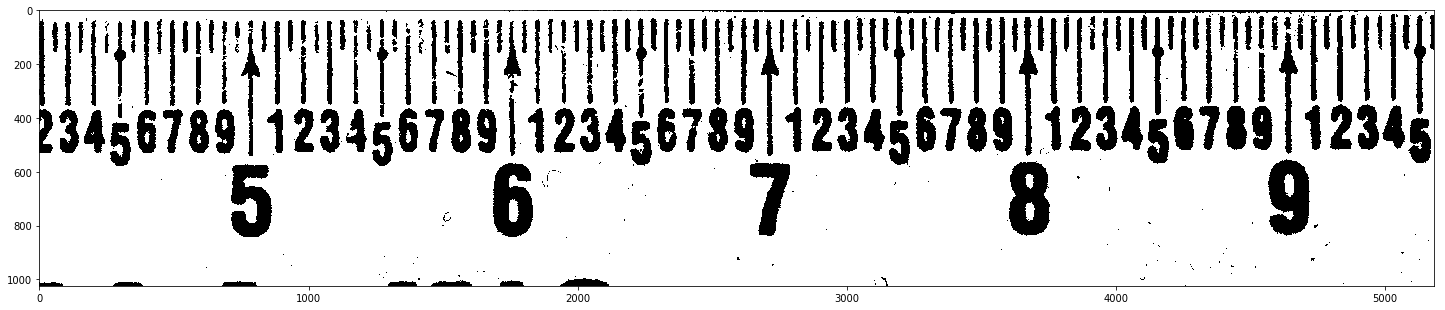

In [22]:
ruler_edge_position = get_ruler_edge_convolution(binary, 100)
plt.imshow(binary[ruler_edge_position:], cmap=plt.cm.gray)

# Butterfly Cropping

In [23]:
avg_col_values = np.mean(binary.T, 1)
print(avg_col_values.shape)
avg_col_values

(5184,)


array([ 0.23784722,  0.20283565,  0.18373843, ...,  0.25810185,
        0.2583912 ,  0.25925926])

2441

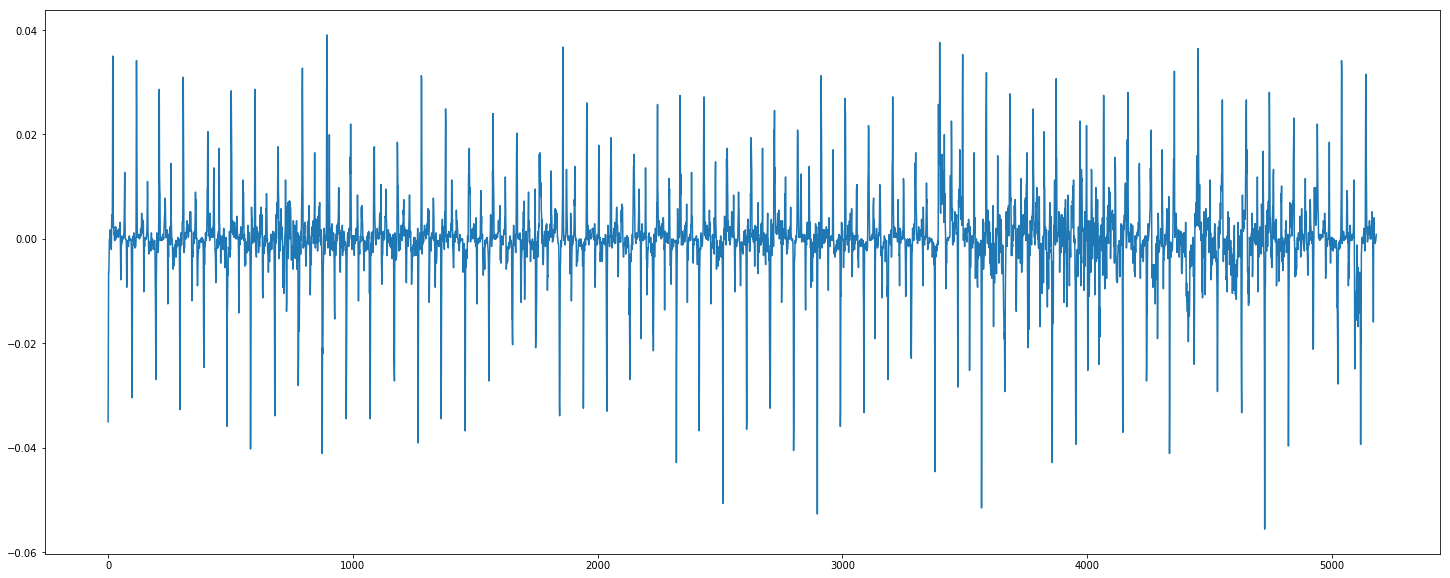

In [24]:
col_diff = np.diff(avg_col_values, n=1)
plt.plot(col_diff)
np.argmax(row_diff)

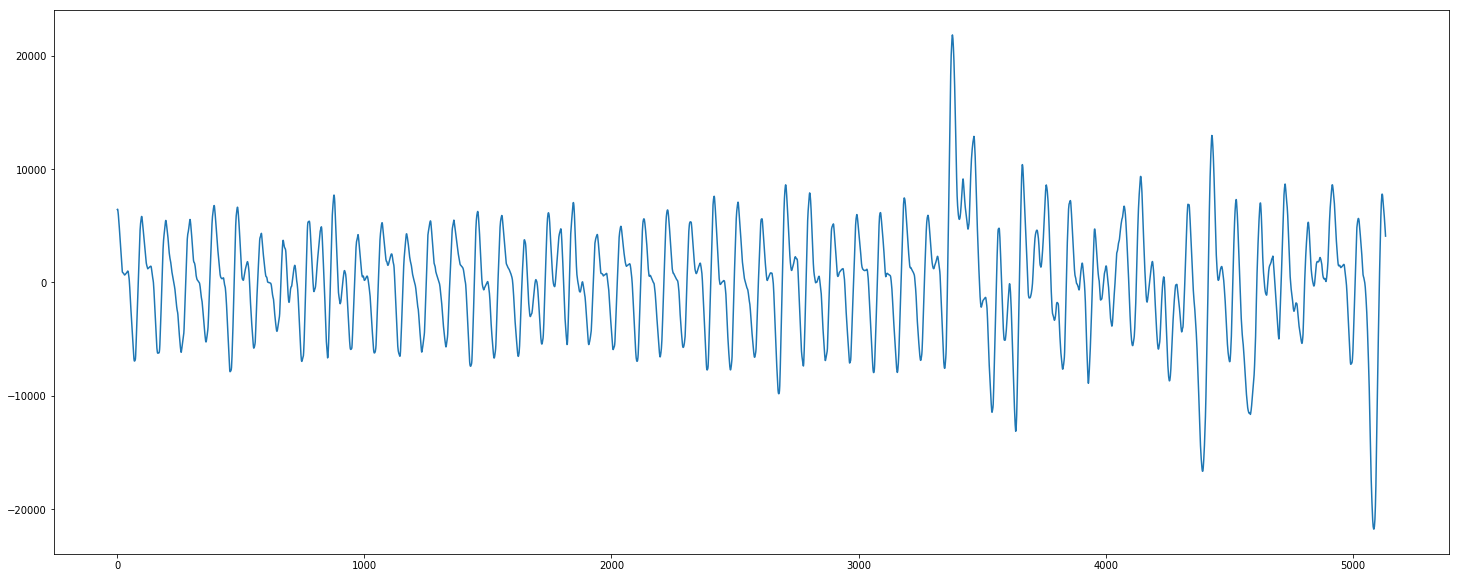

In [25]:
butterfly_kernel_height = 50
butterfly_kernel_neg_ones = -np.ones((binary.shape[0], butterfly_kernel_height//2))
butterfly_kernel_ones = np.ones((binary.shape[0], butterfly_kernel_height//2))
butterfly_kernel = np.concatenate((butterfly_kernel_neg_ones, butterfly_kernel_ones), axis=1)


butterfly_convolve_result = np.empty(binary.shape[1] - butterfly_kernel_height)

for i in range(butterfly_convolve_result.shape[0]):
    splice = binary[:, i: i+butterfly_kernel_height]
    mul_result = np.multiply(butterfly_kernel, splice)
    butterfly_convolve_result[i] = np.sum(mul_result)

plt.plot(butterfly_convolve_result)
butterfly_cutoff = np.argmax(butterfly_convolve_result) + butterfly_kernel_height//2

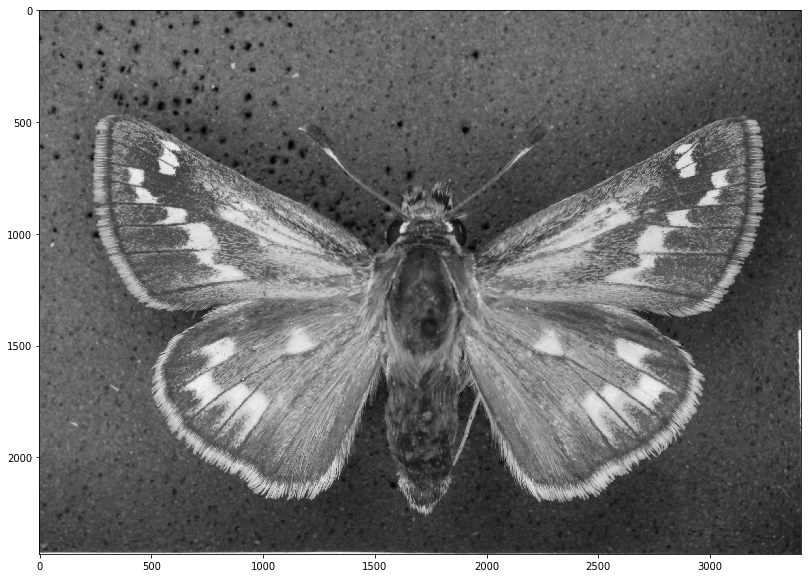

In [26]:
plt.imshow(image[:ruler_edge_position, :butterfly_cutoff], cmap=plt.cm.gray)

In [27]:
def get_butterfly_edge_convolution(binary, butterfly_kernel_height):
    butterfly_kernel_neg_ones = -np.ones((binary.shape[0], butterfly_kernel_height//2))
    butterfly_kernel_ones = np.ones((binary.shape[0], butterfly_kernel_height//2))
    butterfly_kernel = np.concatenate((butterfly_kernel_neg_ones, butterfly_kernel_ones), axis=1)

    butterfly_convolve_result = np.empty(binary.shape[1] - butterfly_kernel_height)

    for i in range(butterfly_convolve_result.shape[0]):
        splice = binary[:, i: i+butterfly_kernel_height]
        mul_result = np.multiply(butterfly_kernel, splice)
        butterfly_convolve_result[i] = np.sum(mul_result)

    return np.argmax(butterfly_convolve_result) + butterfly_kernel_height//2

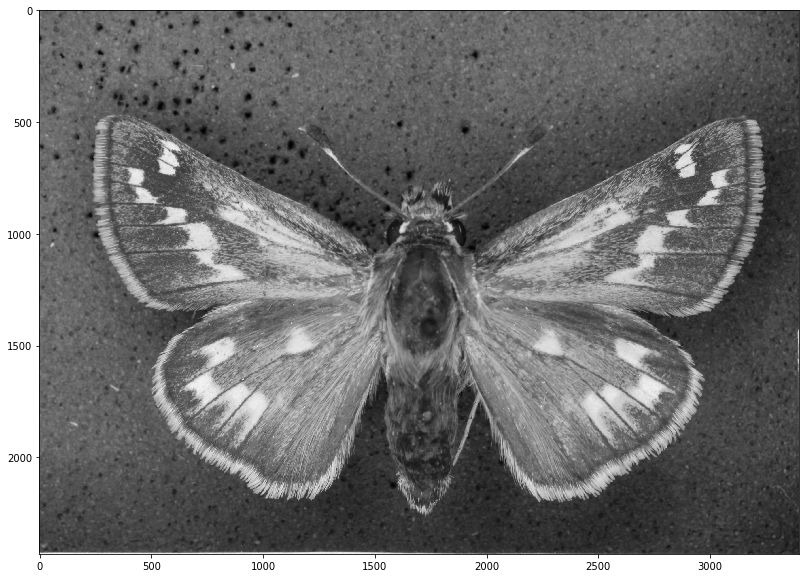

In [28]:
butterfly_edge_position = get_butterfly_edge_convolution(binary, 10)
plt.imshow(image[:ruler_edge_position, :butterfly_edge_position], cmap=plt.cm.gray)

# Theo's Stuff

# Canny Edge Detection

In [29]:
from skimage.feature import canny
from scipy import ndimage as ndi

In [30]:
edges = canny(binary, sigma=2)

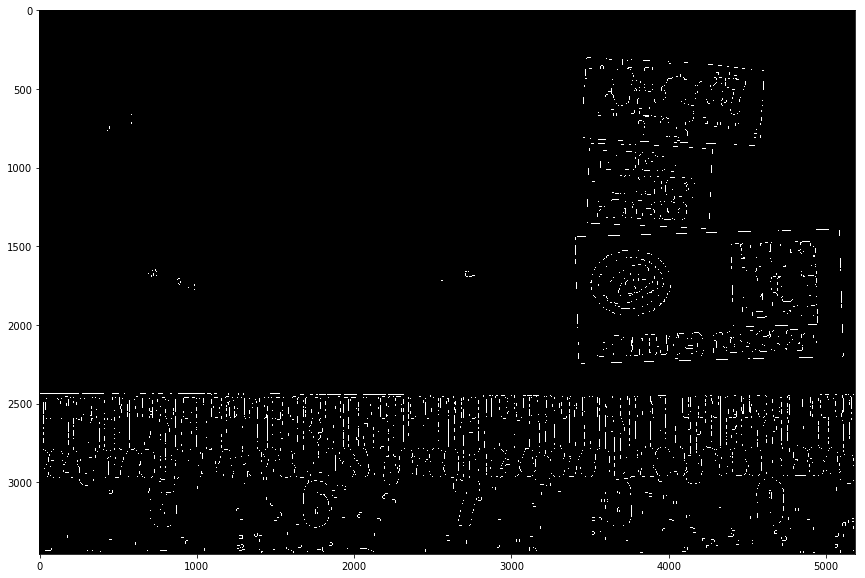

In [31]:
plt.imshow(edges, cmap=plt.cm.gray)

# Watershed

In [32]:
from skimage.filters import sobel
from skimage.morphology import watershed

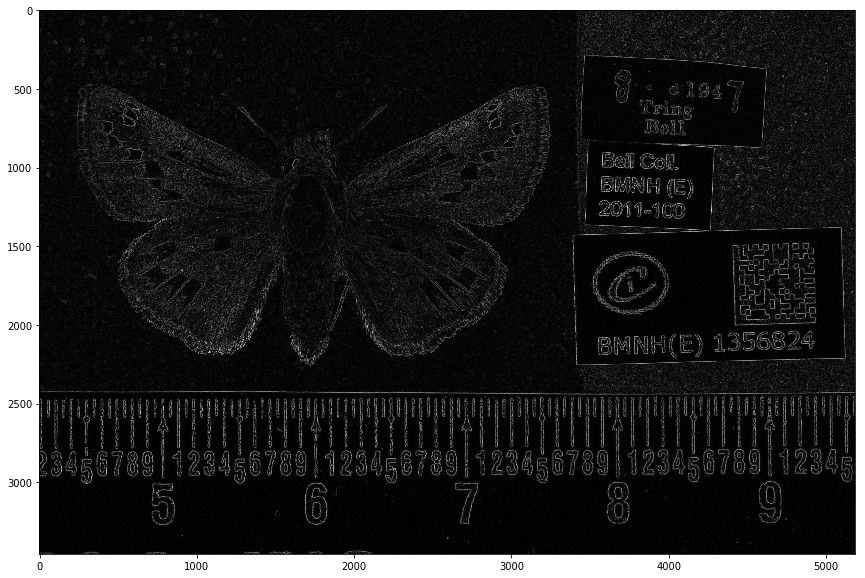

In [33]:
elevation_map = sobel(image)
plt.imshow(elevation_map, cmap=plt.cm.gray)

In [34]:
markers = binary[:,:].astype(int) + 1
markers

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ..., 
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2]])

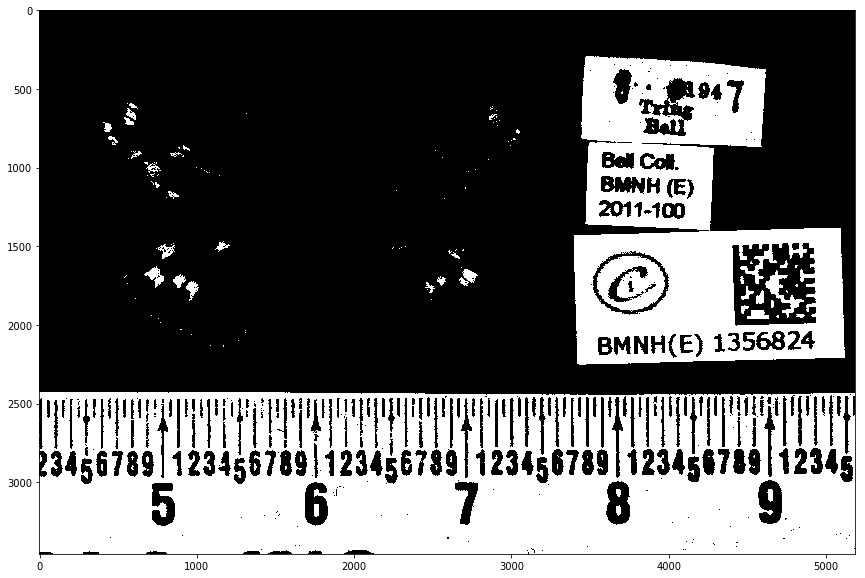

In [35]:
segmentation = watershed(elevation_map, markers)
plt.imshow(segmentation, cmap=plt.cm.gray)

In [36]:
from skimage.color import label2rgb

C:\Anaconda\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


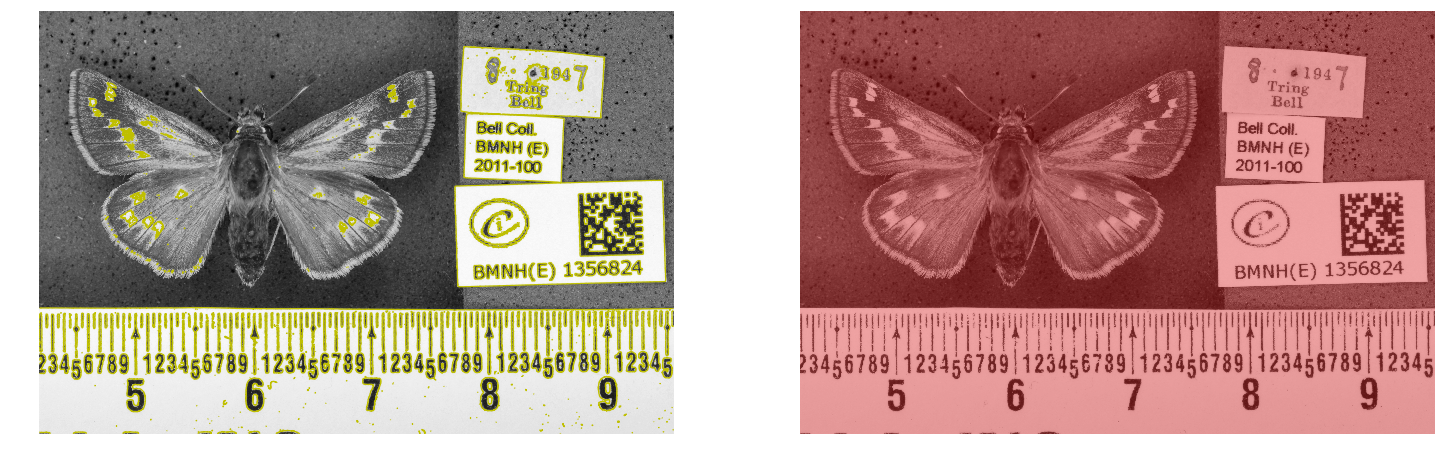

In [37]:
labeled, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled, image=image)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax1.contour(segmentation, [0.5], linewidths=1.2, colors='y')
ax1.axis('off')
ax1.set_adjustable('box-forced')
ax2.imshow(image_label_overlay, interpolation='nearest')
ax2.axis('off')
ax2.set_adjustable('box-forced')

# TODO


- make script to do all the images
- integrate theo's code for ruler distance detection